In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import sys
import matplotlib.pyplot as plt

In [2]:
Path.ls = lambda x:list(x.iterdir())
sys.path.append('../utils/')
from crop_dataset import CropDataset, CropGen
import crops

In [3]:
# if you modify import files
%load_ext autoreload
%autoreload 2

In [4]:
metadata = pd.read_pickle('/project/cq-training-1/project1/data/catalog.helios.public.20100101-20160101.pkl')
metadata = metadata.replace('nan',np.NaN)
metadata = metadata[metadata.ncdf_path.notna()]
new_offset= np.load(Path('/project/cq-training-1/project1/teams/team12/crops-20/new_index.npy'))
metadata = metadata.assign( new_offset = new_offset)    

In [5]:
stations = ['BND','TBL','DRA','FPK','GWN', 'PSU','SXF']

In [6]:
crops.get_crops(metadata,size=20,use_slurm=False)

Data present at /project/cq-training-1/project1/teams/team12


In [28]:
# copy to slurm
crops.get_crops(metadata,size=20,use_slurm=True)

Copying Tar
Extracting


In [7]:
# Run again, no problem
crops.get_crops(metadata,size=20,use_slurm=True)

Data present in destination


In [16]:
# tf Dataset
dataset  = CropDataset(metadata,image_size=20,num_seq=5,use_slurm=True)

In [391]:
# Contents of dataset 
for i,sample in enumerate(dataset):
    print(sample['image'].shape) # seq_len x channel x crop_size x crop_size
    print(sample['station'].numpy())
    print(sample['ghi'].numpy())
    print(sample['csky'].numpy())
    print(sample['timestamp'].numpy())
    break

(1, 5, 20, 20)
[1 0 0 0 0 0 0]
[844.8933  775.13336 415.84     -4.9    ]
[844.3285]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]]


In [392]:
def decode_timestamp(arr):
    day = np.flatnonzero(arr[:31])[0] + 1
    month = np.flatnonzero(arr[31:43])[0] + 1
    hour = np.flatnonzero(arr[43:67])[0]
    minutes = [0,15,30,45][np.flatnonzero(arr[67:])[0]]
    print(month,day,hour,minutes)

In [393]:
decode_timestamp(sample['timestamp'].numpy().flatten())

4 14 19 0


In [394]:
metadata.index[0]

Timestamp('2010-04-14 19:00:00')

In [395]:
# Seq size depends on history present
for i,sample in enumerate(dataset):
    print(sample['image'].shape)
    if i ==10:
        break

(1, 5, 20, 20)
(1, 5, 20, 20)
(1, 5, 20, 20)
(1, 5, 20, 20)
(1, 5, 20, 20)
(1, 5, 20, 20)
(1, 5, 20, 20)
(2, 5, 20, 20)
(2, 5, 20, 20)
(2, 5, 20, 20)
(2, 5, 20, 20)


In [396]:
# The actual generator
gen = CropGen(metadata,image_size=50,use_slurm=False).get_next_sample(num=6)

In [408]:
# Run multiple times and see sequence increase as history increases 
for i,sample in enumerate(gen):
    print(sample['image'].shape)
    if i ==6: break

(6, 5, 50, 50)
(6, 5, 50, 50)
(6, 5, 50, 50)
(6, 5, 50, 50)
(6, 5, 50, 50)
(6, 5, 50, 50)
(6, 5, 50, 50)


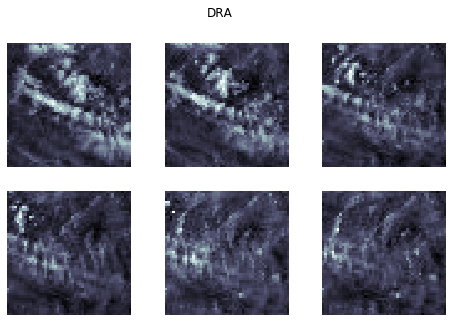

In [409]:
# Sanity Check Run multiple time and see images
sample = next(gen)
_,axs = plt.subplots(2,3,figsize=(8,5))
axs = axs.flatten()
plt.suptitle(stations[np.flatnonzero(sample['station'])[0]])
for i in range(len(sample['image'])):
    axs[i].imshow(sample['image'][i,0],cmap='bone')
    axs[i].axis('off')

plt.show()

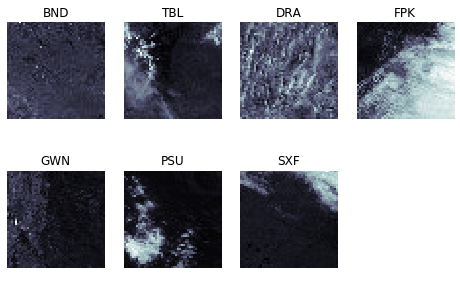

In [8]:
# Another sanity check #Just for me
dt = '2010-04-15 17:15:00'
f = f'/project/cq-training-1/project1/teams/team12/crops-50/{dt[:10]}.npy'
day = np.load(f)
image = day[metadata.at[dt,'new_offset'],:,0]
_,axs = plt.subplots(2,4,figsize=(8,5))
axs = axs.flatten()
for i in range(len(image)):
    axs[i].imshow(image[i],cmap='bone')
    axs[i].axis('off')
    axs[i].set_title(stations[i])
    
plt.axis('off')
plt.show()